<a href="https://colab.research.google.com/github/avecaile/data-boggling/blob/master/Probabilistic_Programming_with_TFP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code below was inspired by the  Colab from the first chapter of [Probabilistic Programming and Bayesian Methods for Hackers](https://colab.research.google.com/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_TFP.ipynb#scrollTo=6Tmmlr92MZVj), so most of the credits go to Cam Davidson-Pilon and the people porting the code to [Tensorflow Probability](https://www.tensorflow.org/probability/).

The full Github repository is available at [github/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)


In [0]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


from __future__ import absolute_import, division, print_function


#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors


def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
           tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

<module 'tensorflow._api.v2.config' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/config/__init__.py'>

## Problem Statement

Let's try to model a situation that concerns the rate at which a user sends and receives whatsapp messages:
> You are given a series of daily WhatsApp-messages counts exchanged by 2 users from your system. The data, plotted over time, appears in the chart below. You are curious to know if the users' WhatsApp-chat habits have changed over time, either gradually or suddenly. How can you model this? (This is in fact the WhatsApp history data between me and my boyfriend.)

Our goal is to determine whether there were changes in trends, sort of an anomaly detection.

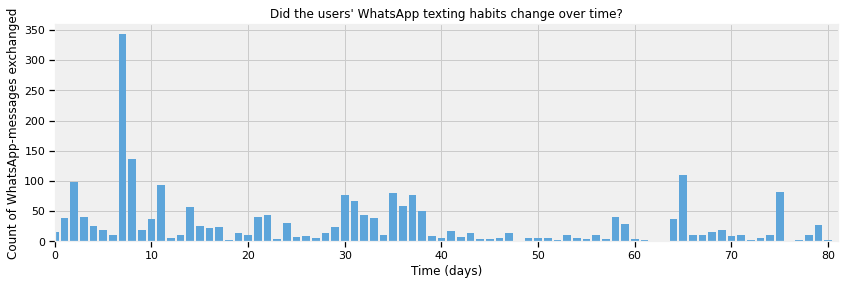

In [0]:
# Defining our data and assumptions
count_data = tf.constant([
    15, 38, 99, 41, 26, 18, 11, 343, 136, 18, 37, 93, 6, 11, 56, 26, 22, 24, 2, 13, 10, 40, 44, 
    3, 30, 7, 8, 6, 14, 23, 76, 67, 44, 39, 10, 80, 58, 77, 50, 8, 6, 17, 7, 14, 3, 3, 6, 13, 1, 
    5, 5, 5, 2, 10, 6, 4, 10, 4, 40, 29, 4, 2, 1, 1, 37, 110, 11, 10, 15, 19, 8, 11, 2, 6, 11, 81, 
    1, 2, 10, 27, 2
], dtype=tf.float32)
n_count_data = tf.shape(count_data)
days = tf.range(n_count_data[0],dtype=tf.int32)

# Visualizing the results
plt.figure(figsize=(12.5, 4))
plt.bar(days.numpy(), count_data, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("Count of WhatsApp-messages exchanged")
plt.title("Did the users' WhatsApp texting habits change over time?")
plt.xlim(0, n_count_data[0].numpy());

How can we start to model this data? A Poisson distribution is generally good for modelling counts and lambda is going to be the mean of this distribution:

$$ C_i \sim \text{Poisson}(\lambda)  $$

Looking at the count data, it appears that the number of WhatsApp message becomes lower for the later period. Therefore, we can consider lambda to be changing by the following logic.
 
$$\lambda = 
\begin{cases} \lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

If no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.


We are going to infer what $\lambda_1, \lambda_2$, and $\tau$ are. They are all probability distributions.

Recall that  𝜆  can be any positive number. An exponential distribution provides a continuous density function, but it has its own hyperparameter called $\alpha$.  

$$
\begin{align}
&\lambda_i \sim \text{Exp}( \alpha ) \\
\end{align}
$$

A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. 



What about 𝜏? We can say that 𝜏 ~ uniform(1,81) since we do not know when is the breakpoint. So we should be able to say that it can be every possible day.

$$
\begin{align}
& \tau \sim \text{DiscreteUniform(1,81) }\\
& \Rightarrow P( \tau = k ) = \frac{1}{81}
\end{align}
$$

Basically, what we are modelling is the poisson function which will generate values based on lambda. Lambda is the average number of events per interval, and it is being estimated by another function called the exponential distribution. 

## Define prior distributions

So to put all of our distributions together, we have:

$$\begin{align*}
\lambda_{1}^{(0)} &\sim \text{Exponential}(\text{rate}=\alpha) \\
\lambda_{2}^{(0)} &\sim \text{Exponential}(\text{rate}=\alpha) \\
\tau &\sim \text{Uniform}[\text{low}=0,\text{high}=1) \\
\text{for }  i &= 1\ldots N: \\
\lambda_i &= \begin{cases} \lambda_{1}^{(0)}, & \tau > i/N \\ \lambda_{2}^{(0)}, & \text{otherwise}\end{cases}\\
 X_i &\sim \text{Poisson}(\text{rate}=\lambda_i)
\end{align*}$$

Let's implement this model using TF and TFP's distributions. Since TF Probability is built on the TensorFlow (TF) stack, it brings the runtime benefits of TF to Bayesian analysis. These include write-once run-many (ability to run your development model in production) and speedups via GPUs and TPUs.

##Build model

In [0]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
 
    alpha = (1. / tf.reduce_mean(count_data))
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
 
    rv_tau = tfd.Uniform()
 
    # lambda_ is an array which gets gathered by the boolean of whether the day is smaller than the sample of tau.
    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.cast(tau * tf.cast(tf.size(count_data), dtype=tf.float32) <= tf.cast(tf.range(tf.size(count_data)), dtype=tf.float32), dtype=tf.int32))
    rv_observation = tfd.Poisson(rate=lambda_)
    # The output is the summation of all individual part log probability.
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
    )


# Define a closure over our joint_log_prob.
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau)

This implementation is arguably very close to being a 1:1 mapping of the probabilistic model.

We want to know the following distribution: $p(\lambda_1, \lambda_2, \tau | X)$. And by Bayes rule gives us: $p(\lambda_1, \lambda_2, \tau | X)$  $\propto$ $p(X|\lambda_1, \lambda_2, \tau)p(\lambda_1)p(\lambda_2)p(\tau)$

Doing inference using this model in TF Probability requires creating a joint log probability function which takes an input of samples and returns the log probability of the given sample in the model.


## Infer by sampling posterior




In [0]:
# wrap the mcmc sampling call in a @tf.function to speed it up
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
  return tfp.mcmc.sample_chain(*args, **kwargs)

# First ~5-10% steps thrown away: “burn-in” process
num_burnin_steps = 5000
num_results = 20000


# Set the chain's start state.
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]


# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

step_size = 0.2

# Putting together all our building blocks to run the MCMC algorithm. 
# The unnormalized_log_posterior function is the the joint_log_prob function with count_data closed out of the input.

kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))


# Sample from the chain.
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = graph_sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_chain_state,
    kernel = kernel)
    
tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(count_data),dtype=tf.float32))

We are using Markov Chain Monte Carlo (MCMC), specifically the Hamiltonian Monte Carlo (HMC) kernel, to generate posterior samples using the model defined above. We are using the property of TF, called automatic differentiation, which automatically computes the gradient for us, which is then used by HMC.

Then we are going to compute the joint probabilities in a fast manner by calling the defined closure.

HMC samples live in Real number space. But our exponential distribution samples and uniform distribution samples live in R+ and (0,1). So we add these 3 independent bijectors to constraint the space we are sampling in (basically make sure that the HMC samples have > 0 probability and  chain doesn't get stuck).


In [0]:
print("acceptance rate: {}".format(
    tf.reduce_mean(tf.cast(kernel_results.inner_results.inner_results.is_accepted,dtype=tf.float32))))
print("final step size: {}".format(
    tf.reduce_mean(kernel_results.inner_results.inner_results.accepted_results.step_size[-100:])))

acceptance rate: 0.476500004529953
final step size: 0.016956288367509842


When the step size is too small, the system is too conservative, and doesn’t explore parameter space rapidly. On the other hand, when step size is too large, the trajectory is unstable and all of the steps basically get rejected during the Metropolis step.
[Theoretical analysis](https://arxiv.org/abs/1001.4460) indicates that the optimal balance of these two factors comes when the acceptance probability is ∼0.651. This isn’t a strict number that you have to nail, but getting the acceptance probability within the 0.4−0.9
 is a good target.



## Plot posterior distributions

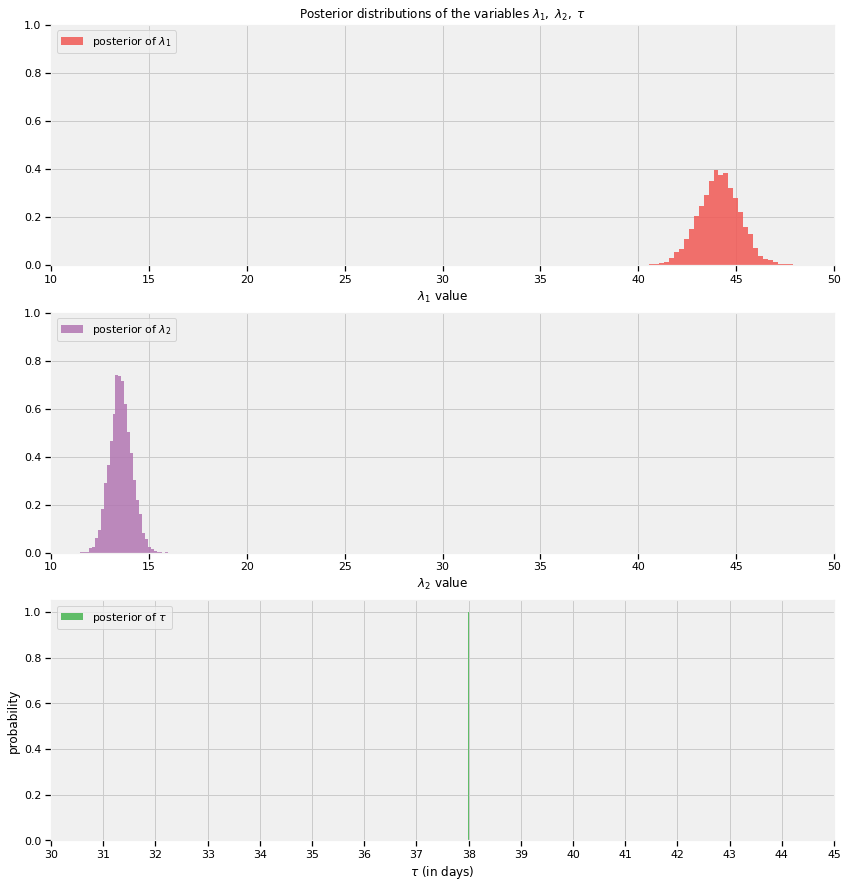

In [0]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", color='#F15854', density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([10, 50])
plt.xlabel(r"$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", color='#B276B2', density=True)
plt.legend(loc="upper left")
plt.xlim([10, 50])
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data[0], alpha=1,
         label=r"posterior of $\tau$",
         color='#60BD68', weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data[0]))
plt.xlim([30, len(count_data)-36])
plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability");

You can see that the plotted samples for lambda1 and lambda2 and part from each other, they do not overlap at all, meaning that were was an actual change happening in the messaging pattern - quite an anomaly!

The posterior distribution of tau suggests with very high probobability that the switch-over happend at around day 38 - not so easy to eyeball this one!

In [0]:
# labels for the days
day_labels = ['2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', 
              '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11', '2020-02-12', 
              '2020-02-13', '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17', 
              '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22', 
              '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27', 
              '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03', 
              '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', 
              '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', 
              '2020-03-14', '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', 
              '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', 
              '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', 
              '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', 
              '2020-04-05', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', 
              '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15', 
              '2020-04-17', '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22', 
              '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27', 
              '2020-04-28', '2020-04-30']

Below we plot the expected number of the WhatsApp message exchanged.

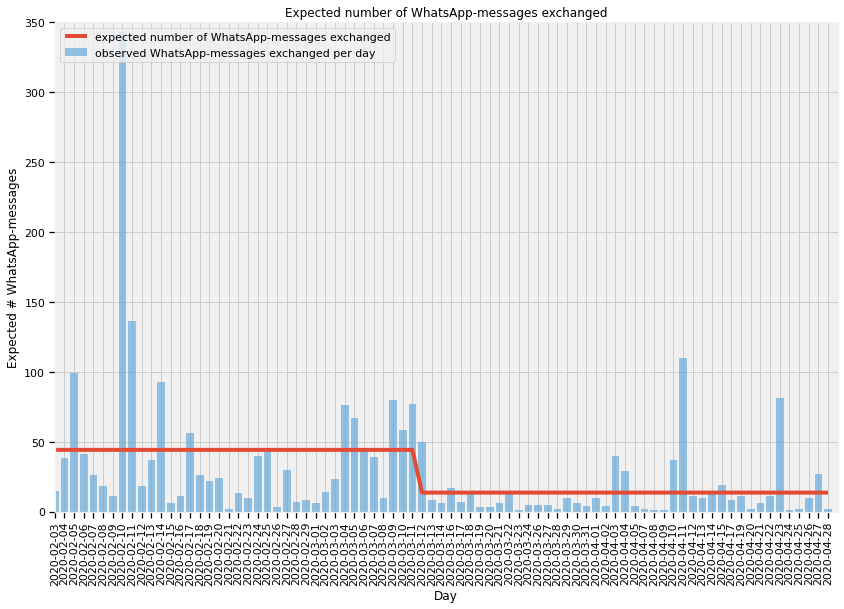

In [0]:
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution

N_ = tau_samples.shape[0]
expected_texts_per_day = tf.zeros(N_,n_count_data.shape[0]) #(10000,81)

plt.figure(figsize=(12.5, 9))

day_range = tf.range(0,n_count_data[0],delta=1,dtype = tf.int32)

# expand from shape of 81 to (10000,81)
day_range = tf.expand_dims(day_range,0)
day_range = tf.tile(day_range,tf.constant([N_,1]))

# expand from shape of 10000 to 10000,81
tau_samples_per_day = tf.expand_dims(tau_samples,0)
tau_samples_per_day = tf.transpose(tf.tile(tau_samples_per_day,tf.constant([day_range.shape[1],1])))

tau_samples_per_day = tf.cast(tau_samples_per_day,dtype=tf.int32)
#ix_day is (10000,81) tensor where axis=0 is number of samples, axis=1 is day. each value is true if sampleXday value is < tau_sample value
ix_day = day_range < tau_samples_per_day

lambda_1_samples_per_day = tf.expand_dims(lambda_1_samples,0)
lambda_1_samples_per_day = tf.transpose(tf.tile(lambda_1_samples_per_day,tf.constant([day_range.shape[1],1])))
lambda_2_samples_per_day = tf.expand_dims(lambda_2_samples,0)
lambda_2_samples_per_day = tf.transpose(tf.tile(lambda_2_samples_per_day,tf.constant([day_range.shape[1],1])))

expected_texts_per_day = ((tf.reduce_sum(lambda_1_samples_per_day*tf.cast(ix_day,dtype=tf.float32),axis=0) + tf.reduce_sum(lambda_2_samples_per_day*tf.cast(~ix_day,dtype=tf.float32),axis=0))/N_)

plt.plot(range(n_count_data[0]), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of WhatsApp-messages exchanged")
plt.xlim(0, n_count_data.numpy()[0])
plt.xlabel("Day")
plt.ylabel("Expected # WhatsApp-messages")
plt.title("Expected number of WhatsApp-messages exchanged")
plt.ylim(0, 350)
plt.bar(np.arange(len(count_data)), count_data, color="#5DA5DA", alpha=0.65,
        label="observed WhatsApp-messages exchanged per day")
plt.xticks(np.arange(len(count_data)), day_labels, rotation=90)

plt.legend(loc="upper left");

## Conclusion
This analysis shows:


*   there was a behavioural change (lambda 1 is different from lambda2)
*   the change was sudden rather than gradual (as demonstrated by tau’s peaked posterior distribution)
*   tau = day 38, which corresponds to March 12th 2020, the day I started working from home due to Coronavirus lockdown.
*   a fun fact: an outlier in the communication pattern on February 10th. I initially thought we were making plans for Valentines day, but looking at the logs I realized we had a fight. Communication is important! : )


###Key take-away

When the data of interest is not big enough to be trained on a neural network, we can use a probabilistic model to get meaningful insights.




